In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report as clr
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from  sklearn.metrics import log_loss
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pyspark.sql import SparkSession as sc

In [24]:
spark = sc \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
df = spark.read.csv('nyc_train_validate.csv',header=True,inferSchema =True)
df.createOrReplaceTempView('gugugu')
df_show = spark.sql('SELECT id,person_id,trip_distance,mode FROM gugugu')
df_show.show(5)

+---+---------+-------------+------+
| id|person_id|trip_distance|  mode|
+---+---------+-------------+------+
|  0|        0|         13.4|subway|
|  1|        0|          3.7| drive|
|  2|        0|          9.8| drive|
|  3|        0|         11.1| drive|
|  4|        0|          2.5| drive|
+---+---------+-------------+------+
only showing top 5 rows



In [25]:
spark.sql('SELECT person_id, AVG(trip_distance) as avg_dis FROM gugugu GROUP BY person_id ').show(5)

+---------+------------------+
|person_id|           avg_dis|
+---------+------------------+
|      148|4.4837837837837835|
|      463|1.1588235294117646|
|      471|0.4000000000000001|
|      496|0.3793103448275861|
|      833|              0.24|
+---------+------------------+
only showing top 5 rows



## Task - predicting the choice of transport mode for different people with the trip

# 1 initial exploration

- Identify quality issues (e.g. missing values, wrong measurements, …)

- Assess feature quality – how relevant is a certain measurement (e.g. use correlation matrix)

- Get an idea on the value distribution of your data using statistical measures and visualizations

### 1.1 quality identification

In [32]:
# Here we present all the columns we have
[x[0] for x in df.dtypes if x[1]!='int']

['travel_date', 'survey_language', 'disability', 'trip_distance', 'mode']

In [27]:
for i in list(df.columns):
    if df[df[i] == -9998].count() != 0: # The missing value is filled with -9998
        print(i)

person_id
o_purpose_category
license
planning_apps
industry
gender
education
res_type
rent_own
income_aggregate


### 1.2 feature quality assessment

In [9]:
# df_data = pd.read_csv('nyc_train_validate.csv')
# from pyspark.ml.linalg import Vectors
# from pyspark.ml.stat import Correlation

In [33]:
df_data = df.toPandas()

<AxesSubplot:>

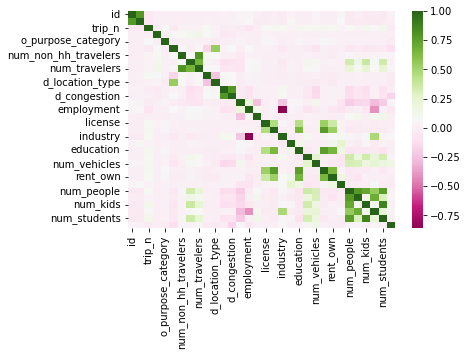

In [34]:
sns.heatmap(df_data.corr(),cmap="PiYG")

### 1.3 value distribution

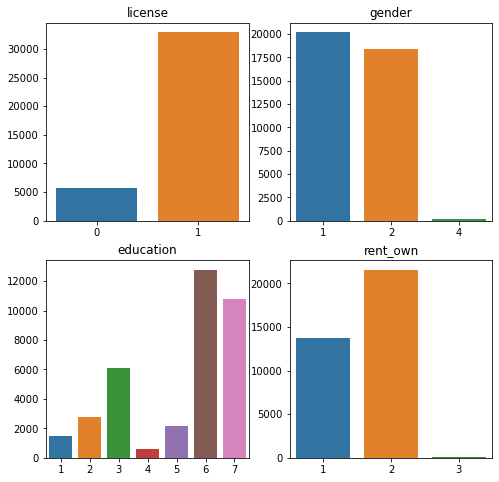

In [35]:
# we would like to see if the distribution of some value is biased
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for n,i in enumerate(['license','gender','education','rent_own']):
    row = int(n/2)
    col = n%2

    data = df_data[i].drop(index= df_data[i][df_data[i]==-9998].index)
    data_dict = dict(data.value_counts())
    keys = list(data_dict.keys())
    values = list(data_dict.values())

    axes[row][col].set_title(i)
    sns.barplot(ax=axes[row][col] ,x = keys, y = values)

# 2 ETL (extract transform load)

accessing the data source, transforming it in a way it can be easily worked with and finally make it available to downstream analytics processes – either real-time streaming or batch ones

In [60]:
# since the data samples is already a dataframe, it's very convenient to process. The rows represents the sample and cols for the features.
print(df.count(),len(df.columns))

39498 36


In [ ]:
# The feature preprocess for machine learning and deep learning module are written seperately in each module

# 3 Feature Creation

### 3.1 Data Cleansing

In [62]:
# In the initial exploration, we find some features are biased. We do not want our model to overfit the specific type in the features and ignore others.
# Especially for the person id, in this way, we will seperate the training set, validation set and test set based on the person_id.
df_data.person_id.unique()

array([   0,    1,    2, ..., 1792, 1793, 1794], dtype=int64)

In [16]:
def train_val_test_split(df_data, search_columns):

    df_train = df_data[df_data.person_id < 1300]
    df_mid = df_data[df_data.person_id < 1600]
    df_val = df_mid[df_mid.person_id >= 1300]
    df_test = df_data[df_data.person_id >= 1600]

    return df_train,df_val,df_test


In [19]:
# The next thing to deal is transfer the datatime object from time series to dayweek
date_time = pd.to_datetime(df_data['travel_date'], format='%d/%m/%Y').dt.dayofweek # change week time
df_data['travel_date'] = date_time

In [20]:
def transform_mode(x):
    if x=='walk':
        x = 0
    elif x=='drive':
        x = 1
    elif x == 'subway':
        x = 2
    elif x == 'bus':
        x = 3
    elif x == 'passenger':
        x = 4
    elif x == 'bike':
        x = 5
    elif x == 'other':
        x = 6
    else:
        x = 7
    return x

df_data['mode'] = df_data['mode'].apply(transform_mode)

### 3.2 Feature Engineering

#### 3.2.1 one-hot encoding

In [21]:
def Get_D(name,data):
    """Apply getting dummies method to change the categorical features

    Args:
        name (string): the column name of the categorical feature
        data (dataframe): the input dataset

    Returns:
        dataframe: the dataframe after changing the categorical features
    """
    res = pd.get_dummies(data[name]).rename(columns=lambda x:name+'_' +str(x))
    data = data.join(res)
    data.drop(columns=[name], inplace=True)
    return data


#### 3.2.2 dealing with missing value and over all preprocess

In [22]:
# Since the missing value is due to the unwilliness of respondents, we though it might represent 'something', and we keep it as a feature

from encodings import search_function


def pre_process_train(data):

    """
    preprocess the train data.
    data : train_data, dataframe object
    """

    # get dummies of categorical column
    names=['travel_date','survey_language','disability','o_location_type','d_location_type','res_type',
    'rent_own','o_purpose_category','d_purpose_category','age','employment','student','planning_apps','industry','gender','education','income_aggregate']
    
    for name in names:
        data = Get_D(name,data)
    
    data.drop(columns=['id','trip_n'], inplace=True) # keep person_id for spliting

    search_columns = data.columns.drop(['mode','person_id'])

    return data,search_columns

#### 3.2.3 Scaling/Normalizing

In [23]:
def feature_normal(df_data, search_columns):

    # Here we also split train and val based on different person id
    df_train,df_val,df_test = train_val_test_split(df_data, search_columns)


    X_train = df_train[search_columns]
    X_val = df_val[search_columns]
    X_test = df_test[search_columns]
    y_train = df_train['mode']
    y_val = df_val['mode']
    y_test = df_test['mode']

    
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_val_std = sc.transform(X_val)
    X_test_std = sc.transform(X_test)

    return X_train_std, X_val_std, X_test_std ,y_train, y_val, y_test

#### 3.2.4 PCA analysis 

In [24]:
data,search_columns = pre_process_train(df_data)
X_train_std, X_val_std, X_test_std ,y_train, y_val, y_test = feature_normal(data, search_columns)
len(search_columns)

137

In [25]:
# In general, applying PCA before building a model will NOT help to make the model perform better (in terms of accuracy)!

# This is because PCA is an algorithm that does not consider the response variable / prediction target into account. 
# PCA will treat the feature has large variance as important features, but the feature has large variance can have noting to do with the prediction target.

# This means, you can produce a lot of useless features and eliminate useful features after PCA.

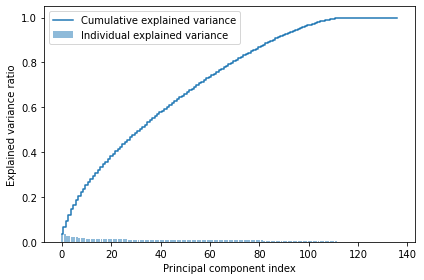

In [26]:
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
# from the figure below, we can project the dimenshion from 137 to 117

pca = PCA(n_components=117)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.fit_transform(X_val_std)


# 4 Model Definition

Therefore, we will not use the feature maintained by pca analysis

### 4.1 Machine Learning method

In [137]:
# with SVM
clf_svc = SVC(gamma='auto',probability=False)
clf_svc.fit(X_train_std,y_train)
y_test_predict = clf_svc.predict(X_test_std)
print(clr(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1626
           1       0.66      0.73      0.69      1208
           2       0.47      0.42      0.44       418
           3       0.47      0.07      0.12       285
           4       0.33      0.24      0.28       296
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        81

    accuracy                           0.63      3953
   macro avg       0.37      0.33      0.33      3953
weighted avg       0.59      0.63      0.59      3953



In [71]:
# with SVM
clf_svc = SVC(gamma='auto',probability=True)
clf_svc.fit(X_train_std,y_train)
print(log_loss(y_test, clf_svc.predict_proba(X_test_std)))

1.0480305395122715


In [138]:
# with the random forest
rf_params = {
    'n_estimators': [20,50,100],
    'min_samples_split':[2,3,4],
    'max_depth': [2,4], 
    'min_samples_leaf': [2,4],
    "bootstrap":[True,False],
}

clf = RandomForestClassifier()
grid = GridSearchCV(clf, rf_params, cv=5)
grid.fit(X_train_std,y_train)
best_param = grid.best_params_
y_test_predict = grid.predict(X_test_std)
print(clr(y_test,y_test_predict))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71      1626
           1       0.58      0.82      0.68      1208
           2       1.00      0.00      0.00       418
           3       0.00      0.00      0.00       285
           4       0.00      0.00      0.00       296
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        81

    accuracy                           0.60      3953
   macro avg       0.31      0.24      0.20      3953
weighted avg       0.54      0.60      0.50      3953



In [134]:
print(log_loss(y_test,grid.predict_proba(X_test_std)))

1.2466246117956368


### 4.2 Deep Learning method

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader


class Simple_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(137,200)
        self.fc2 = nn.Linear(200,400)
        self.fc3 = nn.Linear(400,7)
        self.droput = nn.Dropout(0.5)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)

        return x


net = Simple_Net()
MLP_model = Simple_Net()
print(MLP_model)

Simple_Net(
  (fc1): Linear(in_features=137, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=7, bias=True)
  (droput): Dropout(p=0.5, inplace=False)
)


In [45]:
class MyDataset(Dataset):
 
  def __init__(self,x,y):
 
    self.x_train=torch.tensor(x,dtype=torch.float)
    self.y_train=torch.tensor(y,dtype=torch.float)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [171]:
net = Simple_Net()
MLP_model = Simple_Net()

learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
Model_optimizer = torch.optim.SGD(MLP_model.parameters(),lr = learning_rate, weight_decay=1e-5)

num_epochs = 50
## Here we are defining the number of epochs for training our model
validation_loss_min = np.Inf 
## Here we are initializing the tracker for minimum validation loss, setting initial "min" to infinity

# inputs = torch.from_numpy(np.array(X_train_std)),float()
# targets = torch.from_numpy(np.array(y_train)).float()
train_ds = MyDataset(X_train_std, y_train.values)
train_dl = DataLoader(train_ds, batch_size=200, shuffle=True)

# val_inputs = torch.from_numpy(np.array(X_val_std)),float()
# val_targets = torch.from_numpy(np.array(y_val)).float()
val_train_ds = MyDataset(X_val_std, y_val.values)
val_train_dl = DataLoader(val_train_ds, batch_size=200, shuffle=True)

train_plot_loss = []
val_plot_loss = []
epochs = []

for epoch in range(num_epochs): # monitoring the losses

    training_loss = 0
    validation_loss = 0
    
    for idx,(data,label) in enumerate(train_dl):

        data = data
        label = label.long()

        Model_optimizer.zero_grad()
        output = MLP_model(data)
        loss = criterion(output,label)
        loss.backward()
        Model_optimizer.step()

        training_loss += loss.item()

    training_loss /= idx
    
    if epoch % 5 == 0:

        MLP_model.eval()
        with torch.no_grad():
        
            for idx,(val_data,val_label) in enumerate(val_train_dl):

                val_data = val_data
                val_label = val_label.long()

                val_output = MLP_model(val_data) ## forward passing as in this computing the predicted outputs by passing the inputs to the model

                val_loss = criterion(val_output,val_label) ## Calculating the loss
                validation_loss += val_loss.item()
            
            validation_loss /= idx

            train_plot_loss.append(training_loss)
            val_plot_loss.append(validation_loss)
            epochs.append(epoch)

            print("epoch-{}   train-loss{}   val-loss{}".format(epoch, training_loss,validation_loss))

epoch-0   train-loss1.6398741321431265   val-loss1.572935376316309
epoch-5   train-loss1.2653515777654119   val-loss1.2871847301721573
epoch-10   train-loss1.0883398064308696   val-loss1.1576136983931065
epoch-15   train-loss0.9846006706357002   val-loss1.0927610006183386
epoch-20   train-loss0.9171846380664243   val-loss1.0699491184204817
epoch-25   train-loss0.8649884454078145   val-loss1.0637375619262457
epoch-30   train-loss0.8208271103600661   val-loss1.0659404136240482
epoch-35   train-loss0.7822126348813375   val-loss1.0710848160088062
epoch-40   train-loss0.7466372528837787   val-loss1.0815389454364777
epoch-45   train-loss0.7139123620258437   val-loss1.0943703036755323


In [172]:
y_test_predict = MLP_model(torch.tensor(X_test_std).float())
print(clr(y_test,torch.max(y_test_predict,dim=1)[1].detach().numpy()))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1626
           1       0.63      0.73      0.68      1208
           2       0.46      0.54      0.50       418
           3       0.49      0.12      0.20       285
           4       0.41      0.36      0.38       296
           5       0.00      0.00      0.00        39
           6       0.00      0.00      0.00        81

    accuracy                           0.64      3953
   macro avg       0.39      0.36      0.36      3953
weighted avg       0.61      0.64      0.62      3953



In [173]:
# print(log_loss(y_test,MLP_model(torch.tensor(X_test_std).float()).detach().numpy()))

In [174]:
print(criterion(MLP_model(torch.tensor(X_test_std).float()),torch.tensor(y_test.values)))

tensor(1.0780, grad_fn=<NllLossBackward0>)


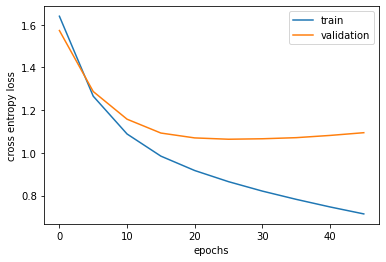

In [175]:
### 自己分出一个测试集
### 按照person id 区分验证集和测试集
### 在测试集上测试效果
### 画loss的图
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
sns.lineplot(x=epochs,y=train_plot_loss, label='train')
sns.lineplot(x=epochs,y=val_plot_loss,label='validation')
plt.legend()

In [127]:
search_columns

Index(['travel_date_dow', 'num_non_hh_travelers', 'num_hh_travelers',
       'num_travelers', 'o_congestion', 'd_congestion', 'license',
       'num_bicycles', 'num_vehicles', 'num_people',
       ...
       'education_5', 'education_6', 'education_7', 'income_aggregate_-9998',
       'income_aggregate_1', 'income_aggregate_2', 'income_aggregate_3',
       'income_aggregate_4', 'income_aggregate_5', 'income_aggregate_6'],
      dtype='object', length=137)

# 5 Model Evaluation

<AxesSubplot:xlabel='classifier', ylabel='1/accuracy'>

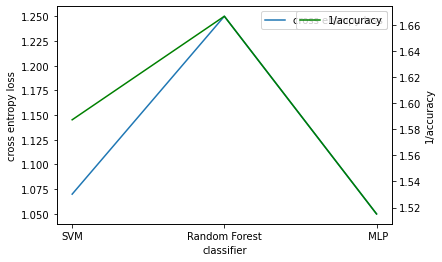

In [166]:
# for test performance

from turtle import color


x_plot = ['SVM','Random Forest', ' MLP']
accuracy = [1/0.63,1/0.60,1/0.66] # best results stored
log_loss = [1.07,1.25,1.05]

d = {
    '1/accuracy':accuracy,
    'cross entropy loss': log_loss,
    'classifier': x_plot

}
eva_data = pd.DataFrame(data=d)
sns.lineplot(x="classifier", y="cross entropy loss",data=eva_data,label = 'cross entropy loss')
ax2 = plt.twinx()
sns.lineplot(x="classifier", y="1/accuracy",data=eva_data, label = '1/accuracy',ax=ax2,color='g')

In [ ]:
### 加上注释，写成一份完整的报告样式，加上分析